Notebook to try various baseline upscaling estimates

In [209]:
## Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import statsmodels as sm
from statsmodels.formula.api import ols
from latlon_utils import get_climate

# import powerlaw

analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/'

## Start with Kuhn 2021 regression equations from BAWLD-CH4.

### Try to replicate coefficients

In [257]:
## Load
df = pd.read_csv('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/archive/BAWLD_CH4_Aquatic.csv', 
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df)

## Filter and pre-process
df.query("SEASON == 'Icefree' ", inplace=True) # and `D.METHOD` == 'CH'
df.dropna(subset=['SA', 'CH4.D.FLUX', 'TEMP'], inplace=True)

## if I want transformed y as its own var
df['CH4.D.FLUX.LOG'] = np.log10(df['CH4.D.FLUX']+1) 

## print filtering
len1 = len(df)
print(f'Filtered out {len0-len1} values ({len1} remaining).')
print(f'Variables: {df.columns}')

## View
df.head(2)

Filtered out 341 values (212 remaining).
Variables: Index(['ï»¿ID', 'NUM', 'STUDY', 'DATASET', 'YEAR', 'COUNTRY', 'SITE',
       'NUMBER.LAKES', 'LAT', 'LONG', 'ECOREGION', 'PERMA.ZONE', 'LAKE.TYPE',
       'BOTTOM', 'TALIK', 'SA', 'DEPTH', 'SEASON', 'YEAR.S', 'MONTH',
       'PATHWAY', 'D.METHOD', 'K600_EQ', 'K_REF', 'E.METHOD', 'E.LOCATION',
       'S.METHOD', 'D.DAYS', 'E.DAYS', 'LENGTH', 'CH4.D.FLUX', 'CH4.E.FLUX',
       'Seasonal.Diff.Flux', 'Seasonal.Ebul', 'Seasonal.Storage', 'IBS',
       'TEMP', 'DOC', 'PH', 'ICEFREE.DAYS', 'CLASS', 'SIZE', 'TYPE',
       'CD_Pcp_An', 'BIOME', 'GRID_T', 'NOTES', 'DOI', 'CH4.D.FLUX.LOG'],
      dtype='object')


,ï»¿ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,ICEFREE.DAYS,CLASS,SIZE,TYPE,CD_Pcp_An,BIOME,GRID_T,NOTES,DOI,CH4.D.FLUX.LOG
4,5,2,Bastviken et al. 2004,WIK,2004,Sweden,Bisen,1.0,NaN,NaN,...,245.0,MLOP,M,OP,NaN,NaN,NaN,NaN,https://doi.org/10.1029/2004GB002238,0.230449
6,7,2,Bastviken et al. 2004,WIK,2004,Sweden,Grunnen,1.0,NaN,NaN,...,245.0,MLOP,M,OP,NaN,NaN,NaN,NaN,https://doi.org/10.1029/2004GB002238,0.623249


Text(0.5, 0, 'Mg CH4 / m2 /day')

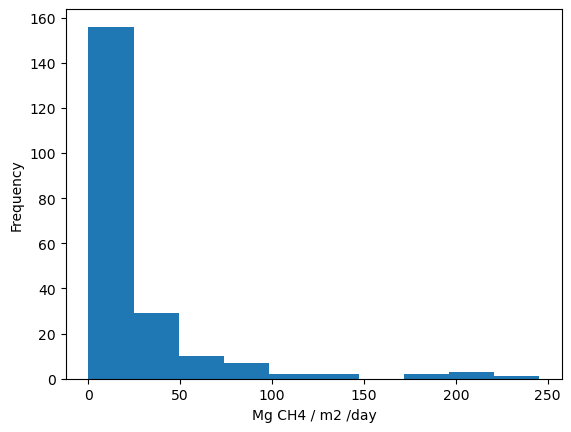

In [278]:
## Viz plot
df['CH4.D.FLUX'].plot.hist()
plt.xlabel('Mg CH4 / m2 /day')

In [264]:
## Linear models (regression)

formula = "np.log10(Q('CH4.D.FLUX')) ~ np.log10(SA) + TEMP" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model1 = ols(formula=formula, data=df).fit()
# print(f'R2: {model1.rsquared:0.3}')
model1.summary() # Their model uses 149 data points with adj r2 = 0.36

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     np.log10(Q('CH4.D.FLUX'))   R-squared:                       0.300
Model:                                   OLS   Adj. R-squared:                  0.293
Method:                        Least Squares   F-statistic:                     44.76
Date:                       Mon, 06 Feb 2023   Prob (F-statistic):           6.62e-17
Time:                               16:24:08   Log-Likelihood:                -146.11
No. Observations:                        212   AIC:                             298.2
Df Residuals:                            209   BIC:                             308.3
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0465      0.118      0.395      0.693      -0.185       0.278
np.log10(SA)    -0.1575      0.030     -5.298      0.000      -0.216      -0.099
TEMP             0.0555      0.008      6.608      0.000       0.039       0.072
==============================================================================
Omnibus:                        4.111   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                3.708
Skew:                          -0.289   Prob(JB):                        0.157
Kurtosis:                       3.293   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [272]:
## Pull out coeffs
model1.params

Intercept       0.046480
np.log10(SA)   -0.157475
TEMP            0.055498
dtype: float64

## Apply models

In [101]:
## I/O This file is the output of QGIS join nearest and when there are multiple nearest BAWLD grid cells (didst 0) to a large lake, multiple rows are created.
# dfHL = pd.read_excel('/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.dbf', usecols=['Hylak_id', 'Shp_Area', 'BAWLDCell_'])
gdfHL = gpd.read_file('/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp', usecols=['Hylak_id', 'Shp_Area', 'BAWLDCell_'])
gdfHL_save = gdfHL


In [73]:
## Take only the first entry for each lake so join  becomes one-one
gdfHL = gdfHL.groupby('Hylak_id').first()

### Join in climate data from WorldClim using pypi package latlon_utils 
(netcdf is in ~/.local/share/latlon_utils/)

In [105]:
## Join in BAWLD attributes
gdfBAWLD = gpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip')
gdfHL = gdfHL.merge(gdfBAWLD[['Cell_ID', 'Long', 'Lat']], left_on='BAWLDCell_', right_on='Cell_ID')

gdfHL.head(3)

,Hylak_id,0-5,5-50,50-95,95-100,Class_sum,Shp_Area,BAWLDCell_,n,distance,feature_x,feature_y,nearest_x,nearest_y,geometry,Cell_ID,Long,Lat
0,2,0.092034,0.071082,57.810849,42.026024,30656.007,30450.64,11887,1,0.0,-122.000000,65.500000,-122.000000,65.500000,"POLYGON ((-119.78782 67.03574, -119.78637 67.0...",11887,-122.25,65.75
1,414668,10.500000,5.500000,84.000000,0.000000,0.200,0.20,11887,1,0.0,-122.457390,65.835295,-122.457390,65.835295,"POLYGON ((-122.45739 65.83529, -122.45475 65.8...",11887,-122.25,65.75
2,414869,17.426273,10.991957,71.581769,0.000000,0.373,0.37,11887,1,0.0,-122.398134,65.826753,-122.398134,65.826753,"POLYGON ((-122.39813 65.82675, -122.39248 65.8...",11887,-122.25,65.75


### Computing temperature means for each lake

In [181]:
## Try dask-ifying and chunking and applying
import dask.dataframe as dd
import dask_geopandas as dgpd
# ddf_HL = dd.from_pandas(gdfHL, chunksize=10000) 
dgdf_HL = dgpd.from_geopandas(gdfHL, chunksize=10000) # assume default sorting provides geosptial partitions, not that it shold matter

In [182]:
## Def functions
def applyGet_climate(ddf):
    '''ddf needs to have 'Lat' and 'Long' attributes'''
    return get_climate(ddf.loc[:, ['Lat']].to_numpy().T.tolist()[0], ddf.loc[:, ['Long']].to_numpy().T.tolist()[0], load_data=True)['tavg']

In [167]:
## Figure out the meta template argument...
ddf_HL.partiloc[0:0, :]

,Hylak_id,0-5,5-50,50-95,95-100,Class_sum,Shp_Area,BAWLDCell_,n,distance,feature_x,feature_y,nearest_x,nearest_y,geometry,Cell_ID,Long,Lat
npartitions=1,,,,,,,,,,,,,,,,,,
0,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,geometry,int64,float64,float64
0,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [183]:
## Test
applyGet_climate(gdfHL[:100])
# type(ddf_HL._partitions(0).compute())

jan        feb        mar       apr       mai        jun  \
lat   lon                                                                       
65.75 -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.148010 -19.419495 -8.281982  1.561279  10.061279   
...                  ...        ...        ...       ...       ...        ...   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   
      -118.25 -27.258728 -26.181763 -19.518738 -9.386230  1.395996  10.359009   

                     jul        aug       sep       oct        nov        dec  \
lat   lon                                                                       
65.75 -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
...                  ...        ...       ...       ...        ...        ...   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   
      -118.25  13.906738  11.414490  5.322754 -3.630981 -15.498779 -23.056274   

                     djf       mam        jja       son       ann  
lat   lon                                                          
65.75 -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.141520 -8.713399  11.148844 -4.756327 -6.365601  
...                  ...       ...        ...       ...       ...  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  
      -118.25 -25.498922 -9.169657  11.893412 -4.602336 -6.844376  

[100 rows x 17 columns]

In [187]:
## Apply
# df_HL_clim = ddf_HL.apply(applyGet_climate, axis=1)
HL_clim = ddf_HL.map_partitions(applyGet_climate).compute()

In [188]:
## View
HL_clim.head(3)

jan       feb        mar       apr       mai        jun  \
lat   lon                                                                      
65.75 -122.25 -24.660522 -23.14801 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.14801 -19.419495 -8.281982  1.561279  10.061279   
      -122.25 -24.660522 -23.14801 -19.419495 -8.281982  1.561279  10.061279   

                     jul        aug       sep       oct        nov        dec  \
lat   lon                                                                       
65.75 -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   
      -122.25  12.846252  10.539001  4.757019 -4.228027 -14.797974 -21.616028   

                    djf       mam        jja       son       ann  
lat   lon                                                         
65.75 -122.25 -23.14152 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.14152 -8.713399  11.148844 -4.756327 -6.365601  
      -122.25 -23.14152 -8.713399  11.148844 -4.756327 -6.365601

In [241]:
# HL_clim.drop(columns='Hylak_id', inplace=True)

In [249]:
## Check that order is preserved in HL_clim

np.all(HL_clim.reset_index()[['lat','lon']].to_numpy() == gdfHL[['Lat', 'Long']].to_numpy())
# HL_clim.reset_index().loc[9999,'lon']
# gdfHL.loc[9999, 'Long']

True

In [307]:
## Check for duplicates
dups = len(gdfHL.Hylak_id) - len(gdfHL.Hylak_id.drop_duplicates())
if dups >0:
    print(f'Warning: {dups} duplicate Hylak_ID found!')

Text(0.5, 0, 'T (C)')

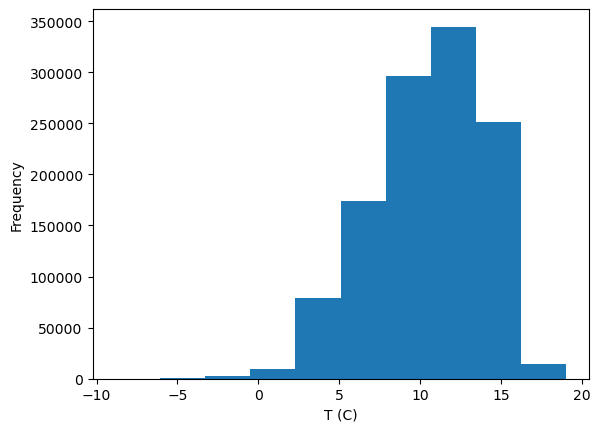

In [280]:
## Verify temp scale
HL_clim_jn.jja.plot.hist()
plt.xlabel('T (C)')

In [309]:
## join in HL ID
HL_clim_jn = pd.concat((HL_clim.reset_index(), gdfHL[['Hylak_id', 'Shp_Area']]), axis=1) # for some reason, just re-assigning column doesn't work

In [252]:
## Write out x2

joined_clim_dir = os.path.join(analysis_dir, 'joined_climate')
os.makedirs(joined_clim_dir, exist_ok=True)

HL_clim_jn.to_csv(os.path.join(joined_clim_dir, 'HL_clim_full.csv'))
HL_clim_jn[['Hylak_id', 'jja', 'Shp_Area']].to_csv(os.path.join(joined_clim_dir, 'HL_clim_jja.csv'))

In [297]:
## Preview file
!head {os.path.join(joined_clim_dir, 'HL_clim_jja.csv')}

,Hylak_id,jja,Shp_Area
0,2,11.148844401041666,30450.64
1,414668,11.148844401041666,0.2
2,414869,11.148844401041666,0.37
3,415195,11.148844401041666,0.1
4,415250,11.148844401041666,0.15
5,415810,11.148844401041666,0.11
6,415986,11.148844401041666,0.28
7,416165,11.148844401041666,0.12
8,416263,11.148844401041666,0.14


## Apply methane prediction

In [310]:
## Drop duplicates! (Why were these there?...)
HL_clim_jn.drop_duplicates(subset='Hylak_id', inplace=True)

In [312]:
## Flux (areal, gCH4/m2/day)
HL_clim_jn['Est_mg_m2_day'] = 10**(model1.params.Intercept +
    model1.params['np.log10(SA)'] * np.log10(HL_clim_jn.Shp_Area) + model1.params['TEMP'] * HL_clim_jn.ann)

## Flux (flux rate, gCH4/day)
HL_clim_jn['Est_g_day'] = HL_clim_jn.Est_mg_m2_day * HL_clim_jn.Shp_Area * 1e3 # (convert km2 -> m2 and mg -> g)

## View
# HL_clim_jn['Est_mg_m2_day'].head()
HL_clim_jn['Est_g_day'].head()

0    2.956284e+06
1    1.271468e+02
2    2.135031e+02
3    7.090555e+01
4    9.977953e+01
Name: Est_g_day, dtype: float64

In [314]:
## Sum! (Tg /yr)
estSum = HL_clim_jn.query('Shp_Area < 5000')['Est_g_day'].sum() * 365.25 / 1e12
print(f'Emissions in BAWLD domain: {estSum:.2} Tg/yr')
print(f"Lake area used: {HL_clim_jn.query('Shp_Area < 5000').Shp_Area.sum():.3} km2")

Emissions in BAWLD domain: 0.18 Tg/yr
Lake area used: 1.02e+06 km2


## TODO:
* apply get_climate function over all hydrolakes using BAWLD cell lat/long X
    * Or, if worldclim netcdf is fine-scale, use individual lake lat/long
* Smart dask way is to define an entire processing chain that ends with writing out
* Apply upscaling calc using lake area (Shp_area) and summer temp X
* If redo-ing, use lake centroid, and then no need to join to BAWLD (and slightly more nuanced, HR temp data)
* C or K?
* Plot, sum, profit!

In [70]:
import dbfread

ModuleNotFoundError: No module named 'dbfread'